# Entanglement detection

In [1]:
## import necessary packages
import sys
import numpy as np
import math
from cmath import cos, sin, exp, pi, sqrt
import random

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["c", "m", "y", "r", "g", "b"]) 

import matplotlib.pyplot as plt
# plt.rcParams['legend.edgecolor'] = "m"
# plt.rcParams['figure.dpi'] = 400
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from qutip import *

from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# import quantum_state_utils
from quantum_state_utils import *


## Entanglement witness

### Dataset generation and Visualize dataset samples

generate_noisy_ghz_ensemble: 3 qubits, 10 samples
generate_coherent_noisy_ghz_ensemble: n = 3, m = 1, theta_limit = 3.14, phi_limit = 3.14


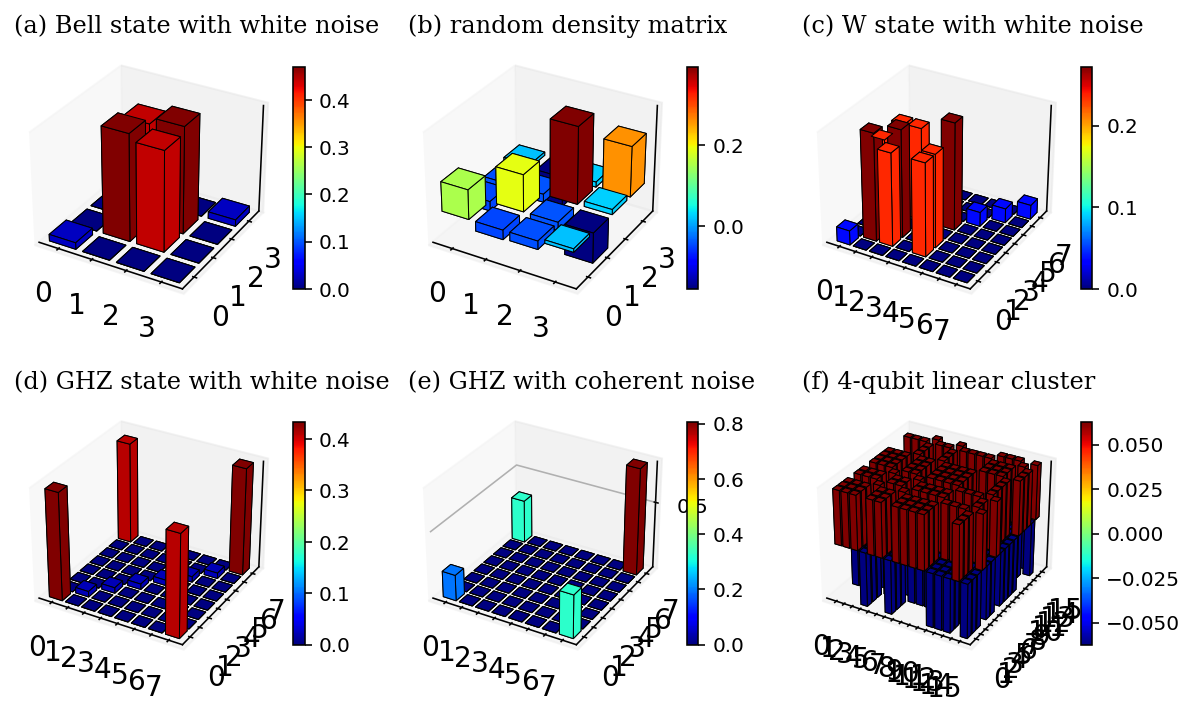

In [6]:
size_train = 10

# visualization
# fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.set_title('(a) Bell state with white noise', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(generate_bell_noisy_density(m=size_train,kind='10',noise_limit=1/3)), fig=fig, ax=ax)
# xlabels=['00', '01', '10', '11'],

# set up the axes for the second plot
# random density matrix
ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.set_title('(b) random density matrix', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice([rand_dm(N=4, dims=[[2, 2], [2, 2]]) for i in range(size_train)]), fig=fig, ax=ax)

# W3 with white noise
w_3_density = generate_noisy_w_ensemble(3,size_train,1/3)
# set up the axes for the first plot
ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.set_title('(c) W state with white noise', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(w_3_density), fig=fig, ax=ax)

# GHZ3 with white noise
ghz_3_density = generate_noisy_ghz_ensemble(3,size_train,1/3)
ax = fig.add_subplot(2, 3, 4, projection='3d')
ax.set_title('(d) GHZ state with white noise', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(ghz_3_density), fig=fig, ax=ax)

# GHZ3 with coherent noise
ax = fig.add_subplot(2, 3, 5, projection='3d')
ax.set_title('(e) GHZ with coherent noise', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(generate_coherent_noisy_ghz_ensemble(n=3,m=1,theta_limit=pi,phi_limit=pi)), fig=fig, ax=ax)

# cluster4 with coherent noise
ax = fig.add_subplot(2, 3, 6, projection='3d')
ax.set_title('(f) 4-qubit linear cluster', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice([ket2dm(generate_linear_cluster(n=4))]), fig=fig, ax=ax)

plt.savefig('dataset_sample_3x2.png', dpi=300)



### 2-qubti unfaithful

# entangled state: 6651 ; # separable state: 3349
number of unfaithful in entangled: 2540


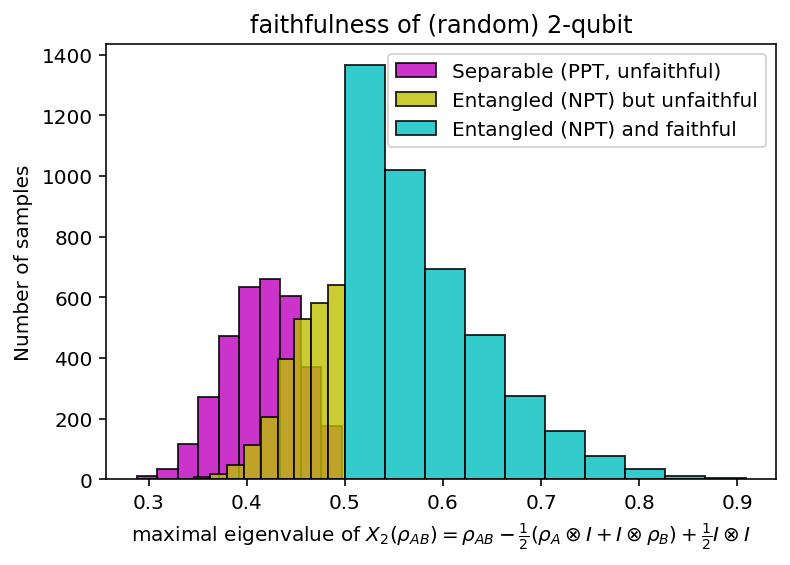

In [5]:
# psi = tensor(basis(2, 0), basis(2, 1))
# print(psi)
# print(psi.ptrace(0))
# print(tensor(psi.ptrace(0),qeye([2])))

# faithfulness of 2-qubit
samples = generate_two_qubit_random_state_PPT(m=10000)

def x_d(rho, d):
    return rho - 1 / d * (tensor(rho.ptrace(0), qeye([d])) + tensor(qeye([d]),rho.ptrace(1))) + 2 / d**2 * qeye([d, d])

x_2_PPT = [ x_d(rho,2) for rho in samples[1] ]
x_2_NPT = [ x_d(rho,2) for rho in samples[0] ]

maximal_x_d_PPT_eigvals = [rho.eigenenergies(sort='high', eigvals=1) for rho in x_2_PPT]
maximal_x_d_NPT_eigvals = [rho.eigenenergies(sort='high', eigvals=1) for rho in x_2_NPT]
unfaithful_entangled = [e for e in maximal_x_d_NPT_eigvals if e <= 0.5]
faithful_entangled = [e for e in maximal_x_d_NPT_eigvals if e > 0.5]
print('number of unfaithful in entangled:', len(unfaithful_entangled))

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylabel('Number of samples')
ax.set_xlabel(r'maximal eigenvalue of $ X_2( \rho_{AB})=\rho_{AB}-\frac{1}{2}(\rho_{A}\otimes I + I \otimes \rho_{B})+\frac{1}{2} I\otimes I $')
ax.set_title('faithfulness of (random) 2-qubit')
ax.hist(np.array(maximal_x_d_PPT_eigvals), alpha=0.8, color=color_config['separable'], edgecolor='k')
ax.hist(np.array(unfaithful_entangled), alpha=0.8, color=color_config['unfaithful'], edgecolor='k')
ax.hist(np.array(faithful_entangled),alpha=0.8,color=color_config['entangled'],edgecolor='k')
# ax.hist(np.array(maximal_x_d_NPT_eigval), alpha=0.7)
ax.legend(['Separable (PPT, unfaithful)','Entangled (NPT) but unfaithful', 'Entangled (NPT) and faithful'])
# plt.savefig('faithfulness_2_qubit.png', dpi=300)

## 2-qubit case

### Bell, CHSH inequalities as entanglement witness

the Bell inequality
$$ \langle a_0b_0, a_0b_0', a_0'b_0, a_0'b_0' \rangle$$
with $a_0=\sigma_x$, $a_0'=\sigma_x$, $b_0=(\sigma_x-\sigma_z)/\sqrt{2}$, and $b_0'=(\sigma_x+\sigma_z)/\sqrt{2}$

the CHSH inequality
$$ \langle \rangle$$

Mermin inequality
yyx+xyy+yxy+xxx

### PPT criterion, Fidelity witness, CHSH

In [7]:
print([ppt_criterion(dm) for dm in generate_bell_like_pure_state(2)])
print([ ppt_criterion(state) for state in generate_rand_product_state(n=2,m=8) ])

[array([-0.45662157]), array([-0.45662157]), array([-0.55868838]), array([-0.55868838]), array([-0.40604261]), array([-0.40604261]), array([-0.4968037]), array([-0.4968037])]
generate_rand_pure_product_state+noise: 2 qubits, 8 samples
[array([-1.38780388e-16]), array([-9.17849334e-17]), array([-7.86592567e-17]), array([-1.26012845e-16]), array([-1.2842564e-16]), array([-1.5237927e-16]), array([-1.25624926e-17]), array([-1.94400942e-17])]


In [5]:
a_0 = sigmaz()
a_1 = sigmax()
b_0 = (sigmax() - sigmaz() )/sqrt(2)
b_1 = (sigmax() + sigmaz())/sqrt(2)

bell_ansatz = [ tensor(a_0,a_1), tensor(a_1,b_0), tensor(a_1,b_1), - tensor(a_0,b_1) ]
bell_inequality = tensor(a_0,a_1) + tensor(a_1,b_0) + tensor(a_1,b_1) - tensor(a_0,b_1) 


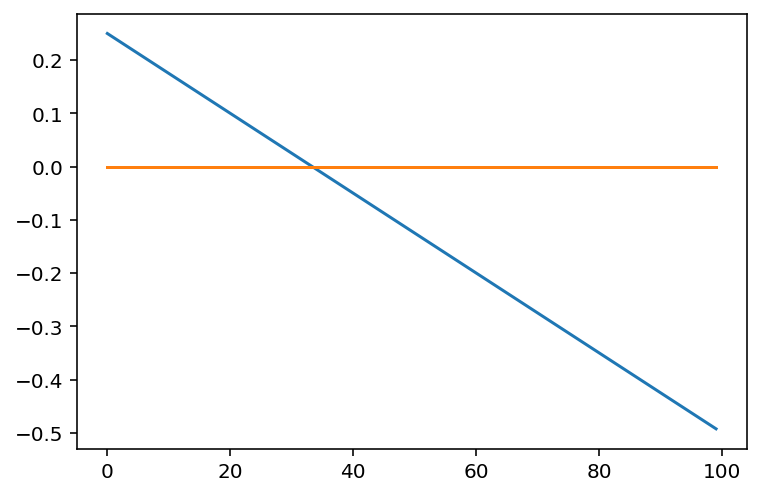

In [43]:
# determine to what extent white noise the Bell state is not entangled
size = 100
white_noise_list = [ i/size for i in range(size) ]
# white_noise_list
white_noise_bell00 = [ p * ket2dm(bell_state('00')) + (1 - p) / 4 * identity([2, 2])  for p in white_noise_list ]
# white_noise_bell00
# np.array([ppt_criterion(rho) for rho in white_noise_bell00]).flatten()
plt.plot(np.array([ppt_criterion(rho) for rho in white_noise_bell00]).flatten())
plt.plot(np.array([0 for i in range(size)]))

### machine learning ansatz

noise limit: 0.33
generate_rand_product_density: 2 qubits, 4000 samples
# tomographic features: 16; selected features: 2
selected Pauli operators ['XI' 'XY']
train score: 0.7218; test score: 0.7025
selected Pauli operators ['XY' 'XZ']
train score: 0.7013; test score: 0.6825
selected Pauli operators ['ZY' 'YX']
train score: 0.7060; test score: 0.6950
selected Pauli operators ['YZ' 'XY']
train score: 0.7050; test score: 0.6837
selected Pauli operators ['IX' 'ZX']
train score: 0.7250; test score: 0.7175
selected Pauli operators ['YI' 'YZ']
train score: 0.7228; test score: 0.6963
selected Pauli operators ['ZY' 'IY']
train score: 0.7221; test score: 0.7137
selected Pauli operators ['YX' 'IY']
train score: 0.7303; test score: 0.7225
selected Pauli operators ['IZ' 'YX']
train score: 0.9342; test score: 0.9200
selected Pauli operators ['IZ' 'YZ']
train score: 0.9300; test score: 0.9175
selected Pauli operators ['IY' 'XZ']
train score: 0.8176; test score: 0.7975
selected Pauli operators ['YZ' '

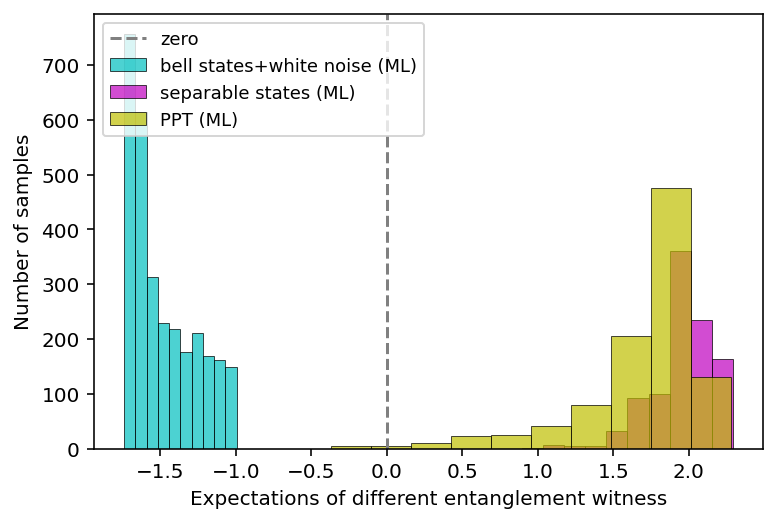

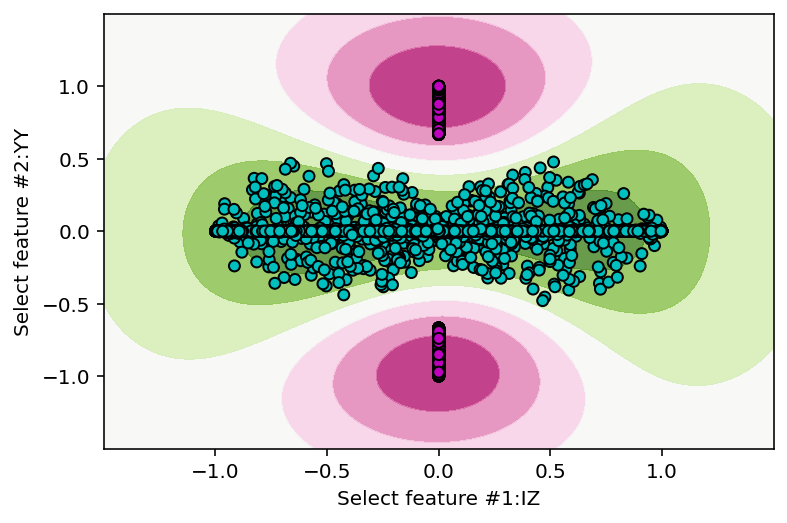

In [3]:
# traing with the entries of the density matrix

size_train = 1000
size_test = 100
bell_noise = 1 / 3
print(f'noise limit: {bell_noise:.2f}')

bell00_noisy = generate_bell_noisy_density(size_train*2, '00', bell_noise)
# print(bell00_noisy_density[0])
bell01_noisy = generate_bell_noisy_density(size_train*2, '01', bell_noise)
bell10_noisy = generate_bell_noisy_density(size_train*2, '10', bell_noise)
bell11_noisy = generate_bell_noisy_density(size_train*2, '11', bell_noise)

bell_like_train = bell00_noisy[:size_train] + bell01_noisy[:size_train] + bell10_noisy[:size_train]+ bell11_noisy[:size_train]

two_product_states = generate_rand_product_density(n=2, m=len(bell_like_train))
# bell_like_train = bell00_noisy + bell01_noisy + bell10_noisy + bell11_noisy
bell_states_lables = [bell_like_train, const_label(0, len(bell_like_train))]

# two_qubit_product_states_train = generate_rand_product_state(n=2, m=len(bell_like_train))
two_product_states_lables = [ two_product_states, const_label(1, len(two_product_states)) ]

# two_pauli, two_label = tomographic_ansatz(n_qubit=2,n_feature=9)

X, y = construct_training_dataset(
    states_labels=[bell_states_lables, two_product_states_lables],
    operators=two_pauli_tomo_operators)

# (X, Y) = assemble_training_dataset(size_train)
to_features = 2
print(f'# tomographic features: {len(two_pauli_tomo_operators)}; selected features: {to_features}')

accuracy = 0.0
while accuracy < 0.99:
    select_indices = random.sample([i for i in range(len(two_pauli_tomo_operators))], to_features)
    select_labels  = two_pauli_tomo_labels[select_indices]
    print('selected Pauli operators:', select_labels)

    # non-linear kernel SVM
    witness, accuracy = svm_train_witness(X=X[:, select_indices], y=y, size_test=size_test)
    # linear kernel SVM with recursive feature elimination
    # witness, accuracy = svm_train_witness(X=X, y=y, size_test=size_test, kernel='linear', to_features=10)

bell_test_features = evaluate_features(operators=two_pauli_tomo_operators,states=bell_like_train[size_train:])
separable_test_features = evaluate_features(
    operators=two_pauli_tomo_operators,
    states=generate_rand_product_density(n=2, m=size_train))
two_qubit_ppt_state_features = evaluate_features(
    operators=two_pauli_tomo_operators, 
    states=generate_random_ppt_state(n_qubit=2,m=size_train))
two_qubit_npt_state_features = evaluate_features(
    operators=two_pauli_tomo_operators, 
    states=generate_random_npt_state(n_qubit=2,m=size_train))

test_expectation_lists = evaluate_witness(witness=witness, features_set=[bell_test_features[:, select_indices],separable_test_features[:, select_indices],two_qubit_ppt_state_features[:, select_indices]])

fig, ax = plt.subplots(figsize=(6, 4))
legends = ['zero', 'bell states+white noise (ML)', 'separable states (ML)', 'PPT (ML)', 'bell inequality']
plot_expectation_hist(ax=ax, expectation_lists=test_expectation_lists, legends=legends, title='')
plt.savefig('two_qubit_bell_ml.png', dpi=300)

plot_feature_space(X=X, y=y, clf=witness, filter=select_indices, labels=select_labels, savefig=False)


### distinguish bi-separable with entangled (2-qubit)

In [3]:
size_train = 1000
train_score_list = []
test_score_list = []
sample_size_list = [200, 300, 600, 800, 1000]
for index, size_train in enumerate(sample_size_list):
    print(f'################ iteration {index}, size of training set: {size_train} ################')
    two_qubit_random_state_PPT = generate_two_qubit_random_state_PPT(size_train,plot=False)
    size = int(0.3*size_train)
    entangled_sample = [two_qubit_random_state_PPT[0][:size], const_label(0,size)]
    separable_sample = [two_qubit_random_state_PPT[1][:size], const_label(1,size)]

    # labels = [ const_label(0,len(entangled_sample)) , const_label(1,len(separable_sample)) ]

    states_labels = [entangled_sample, separable_sample]
    X,y = construct_training_dataset(states_labels=states_labels,operators=two_pauli)
    # X,y = construct_training_dataset(states=[entangled_sample,separable_sample],labels=labels,operators=two_pauli)
    train_score, test_score = my_svm(X=X, y=y, size_test=int(0.1*size_train), kernel='linear',legend=['zero','test - PPT','bell'],rfe=True)
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    # my_svm(X=X, y=y, size_test=100, kernel='rbf',legend=['zero','test - PPT','bell'])


plot_score(sample_size_list,train_score_list,test_score_list)


################ iteration 0, size of training set: 200 ################
# entangled state: 137 ; # separable state: 63


NameError: name 'two_pauli' is not defined

##### Two-qutrit, Two-qudit


In [22]:
# qudit_basis()
x = basis(3, 2)
M = ket2dm(x)
print(M)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


### Three-qubit case (fully separable, biseparable, GME, fully entanglement)

#### Different fidelity witness, different white noise limit (unfaithful)

generate_coherent_noisy_ghz_ensemble: n = 3, m = 1000, theta_limit = 0.50pi, phi_limit = 0.70pi
generate_rand_product_density: 3 qubits, 1000 samples
generate_coherent_noisy_ghz_ensemble: n = 3, m = 1000, theta_limit = 0.50pi, phi_limit = 0.70pi
generate_rand_product_density: 3 qubits, 1000 samples
generate_coherent_noisy_ghz_ensemble: n = 3, m = 1000, theta_limit = 0.50pi, phi_limit = 0.70pi
generate_rand_product_density: 3 qubits, 1000 samples
generate_coherent_noisy_ghz_ensemble: n = 3, m = 1000, theta_limit = 0.50pi, phi_limit = 0.70pi
generate_rand_product_density: 3 qubits, 1000 samples


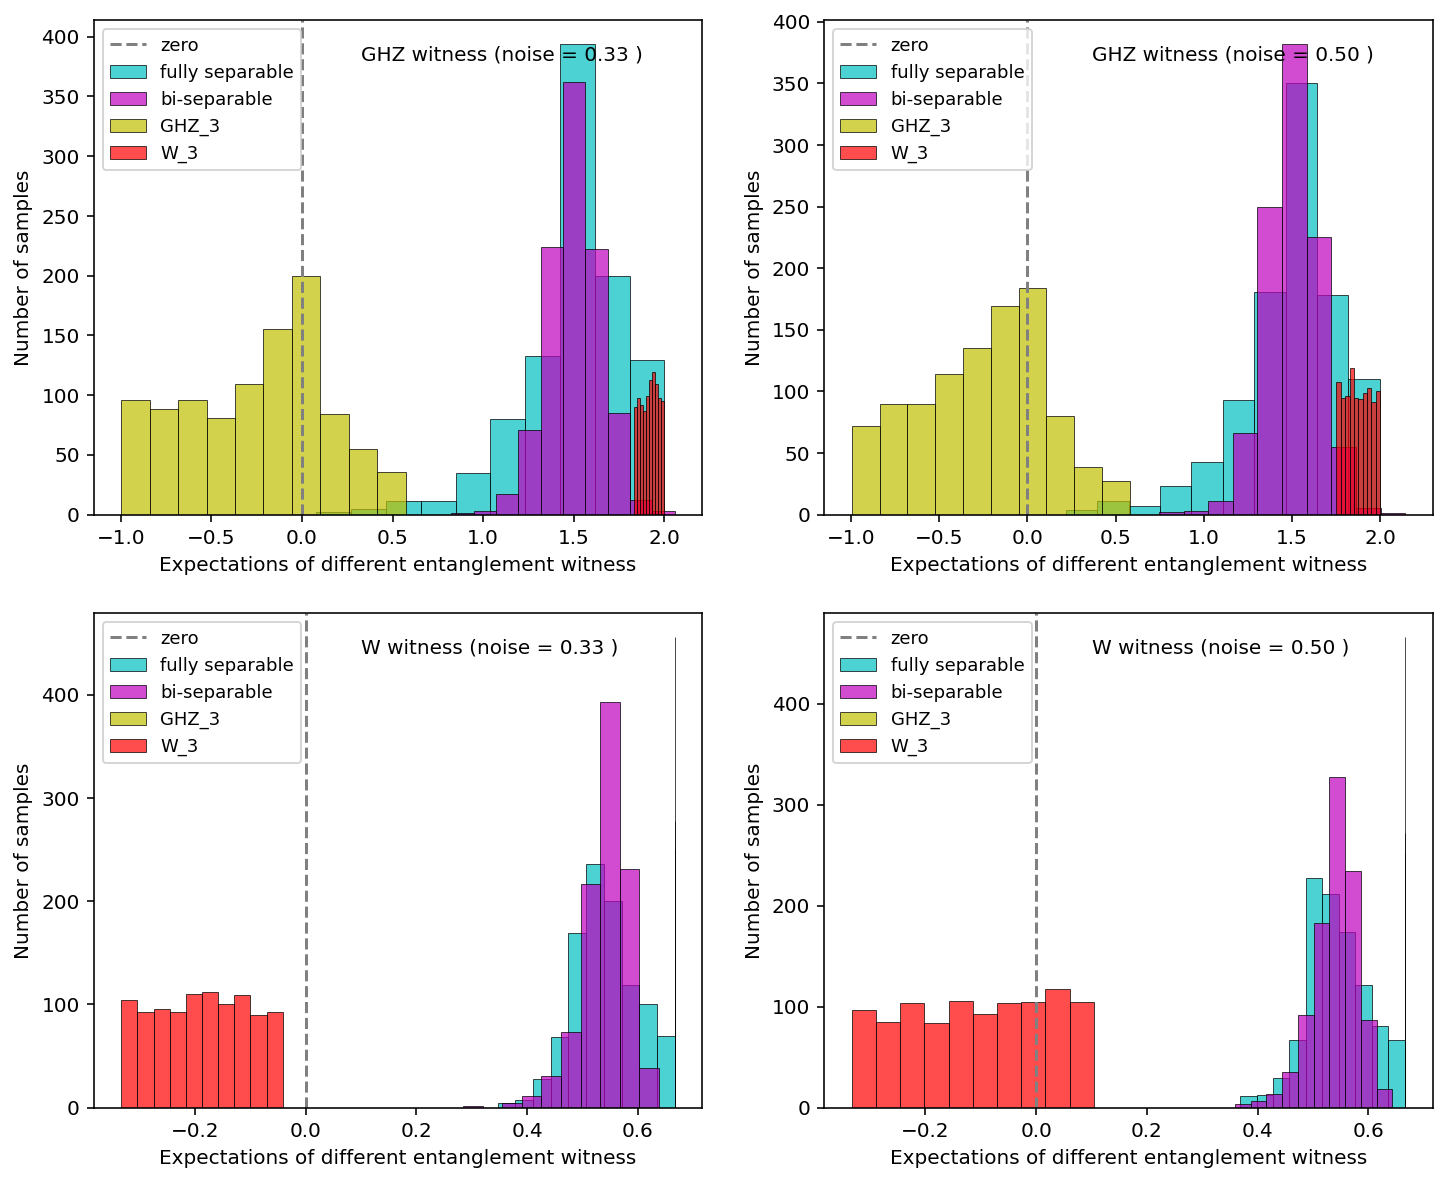

In [5]:
size_train = 1000
size_test = 1000

# noise_limit = 1/5
to_features = 5

# three-qubit tomographic ansatz
# three_pauli = [tensor([a,b,c]) for a in pauli_operators for b in pauli_operators for c in pauli_operators]
# three_pauli = random.sample(three_pauli,to_features)
three_pauli, three_label = tomographic_ansatz(n_qubit=3,n_feature=to_features)


# rigorous entanglement witness - local measurements
witness_ghz_3 =  3/2 * qeye([2, 2, 2]) - tensor([sigmax(), sigmax(), sigmax()]) - 1/2 * (tensor([sigmaz(), sigmaz(), qeye([2])]) + tensor([qeye([2]), sigmaz(), sigmaz()]) + tensor([sigmaz(), qeye([2]), sigmaz()]))
# witness_ghz_3_project = 1/2 * qeye([2, 2, 2]) - ket2dm(ghz_state(N=3))
# stabilizer ...

# rigorous entanglement witness - projection
witness_w_3_project = 2/3 * qeye([2, 2, 2]) - ket2dm(w_state(N=3))

# generate_noisy_biseparable(1,2,10,1/3)
# generate_rand_product_density(3,1,0)

# fig, ax = plt.subplots(figsize=(6, 4))
# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
# ax0 = plt.subplot(1,2,1)
# ax1 = plt.subplot(1,2,2)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# for index, item in enumerate(ranking):
for i, noise_limit in enumerate([1/3, 1/2]):
    for j, witness in enumerate([witness_ghz_3, witness_w_3_project]):
        ## generate training data
        # GHZ and W state samples with white noise
        ghz_3_density = generate_coherent_noisy_ghz_ensemble(n=3, m=size_train, theta_limit=1/2, phi_limit=0.7)
        # ghz_3_density = generate_noisy_ghz_ensemble(n=3,m=size_train,noise_limit=noise_limit)
        w_3_density = generate_noisy_w_ensemble(n=3,m=size_train,noise_limit=noise_limit)

        # test GHZ3/W3 projection witness
        three_qubit_legends = ['zero', 'fully separable','bi-separable','GHZ_3','W_3']
        three_qubit_witness_expectation_list = [
            [expect(witness, state) for state in test_set] for test_set in
            # [expect(witness_ghz_3, state) for state in test_set] for test_set in
            [
                generate_rand_product_density(3, size_train, 0),
                generate_noisy_biseparable(1, 2, size_train, 1/3),
                ghz_3_density,
                w_3_density
            ]
            # [generate_rand_product_state(3, size_train), ghz_3_density, w_3_density]
        ]
        if j == 0:
            title = f'GHZ witness (noise = {noise_limit:.2f} )'
        else:
            title = f'W witness (noise = {noise_limit:.2f} )'
        plot_expectation_hist(axs[j, i],
                              three_qubit_witness_expectation_list,
                              three_qubit_legends,
                              title=title)

# plt.savefig('fidelity_witness_compare.png', dpi=400)

#### Unfaithful, ful entangle, GME: 3-qubit GHZ, W

least eigenvale:  4.1078251911129996e-17 when p= 0.2
least eigenvale:  0.00035145515467440374 when p= 0.209


Text(0, 0.5, 'least eigenvalue / Tr(W rho)')

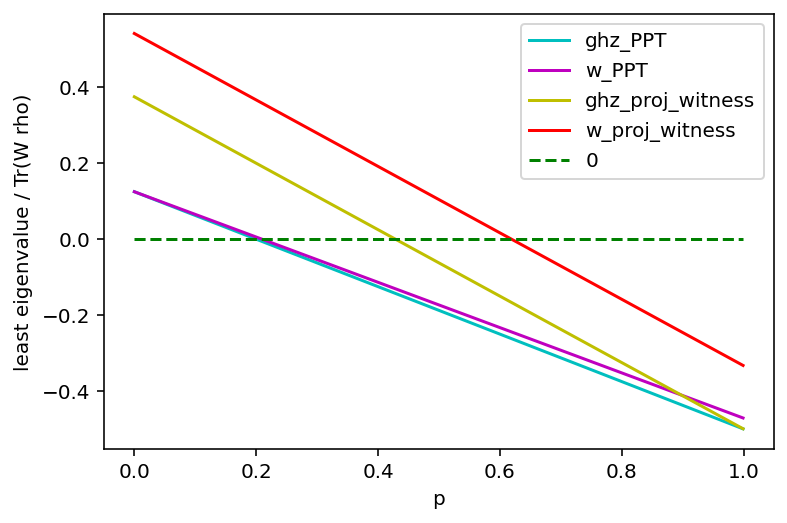

In [16]:
# determine to what extent white noise the Bell/GHZ/W state is not entangled
size = 1000
white_noise_list = [i / size for i in range(size)]
# white_noise_list
white_noise_www = [
    p * ket2dm(w_state(3)) + (1 - p) / 2**3 * qeye([2 for j in range(3)])
    for p in white_noise_list
]

white_noise_ghz = [
    p * ket2dm(ghz_state(3)) + (1 - p) / 2**3 * qeye([2 for j in range(3)])
    for p in white_noise_list
]

# evaluate the least eigenvalues of partial transpose with partition (A|BC)
eigvals_ghz = np.array([ppt_criterion(rho) for rho in white_noise_ghz]).flatten()
eigvals_www = np.array([ppt_criterion(rho) for rho in white_noise_www]).flatten()

def find_maximal_p_entangle(eigval_list):
    for index, item in enumerate(eigval_list):
        if index < size - 1:
            if item * eigval_list[index + 1] < 0:
                print('least eigenvale: ', item,'when p=', index/size)

find_maximal_p_entangle(eigvals_ghz)
find_maximal_p_entangle(eigvals_www)

plt.plot(white_noise_list, eigvals_ghz)
plt.plot(white_noise_list, eigvals_www)
plt.plot(white_noise_list, [3/8-7/8*p for p in white_noise_list])
plt.plot(white_noise_list, [13/24-21/24*p for p in white_noise_list])
plt.plot(white_noise_list, np.array([0 for i in white_noise_list]),'--')
plt.legend(['ghz_PPT','w_PPT','ghz_proj_witness','w_proj_witness','0'])
plt.xlabel('p')
plt.ylabel('least eigenvalue / Tr(W rho)')

### machine learning ansatz
#### Feature elimination
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

generate_rand_product_density_matrix: 3 qubits, 4000 samples
generate_coherent_noisy_ghz_ensemble: n = 3, m = 4000, theta_limit = 0.60*pi, phi_limit = 0.70*pi
# features: 5
selected Pauli operators: ['IZI' 'XZX' 'IXX' 'XIX' 'III']
train score: 0.8281; test score: 0.8275
selected Pauli operators: ['ZZX' 'XXI' 'XIY' 'ZIZ' 'IIZ']
train score: 0.9964; test score: 0.9950
selected Pauli operators: ['YZZ' 'XII' 'ZIY' 'YIZ' 'XXZ']
train score: 0.8200; test score: 0.8263
selected Pauli operators: ['YII' 'ZIX' 'ZIY' 'YZX' 'XXI']
train score: 0.8393; test score: 0.8488
selected Pauli operators: ['YZX' 'ZZZ' 'YIY' 'YIZ' 'IIZ']
train score: 0.9639; test score: 0.9700
selected Pauli operators: ['YXY' 'YXX' 'XXX' 'ZZZ' 'IZX']
train score: 0.9883; test score: 0.9862
selected Pauli operators: ['YII' 'XXZ' 'XZZ' 'ZYI' 'IIY']
train score: 0.9124; test score: 0.9062
selected Pauli operators: ['YZY' 'XXI' 'IZY' 'XIY' 'ZII']
train score: 0.8387; test score: 0.8450
selected Pauli operators: ['XXZ' 'XZX' 'IYZ

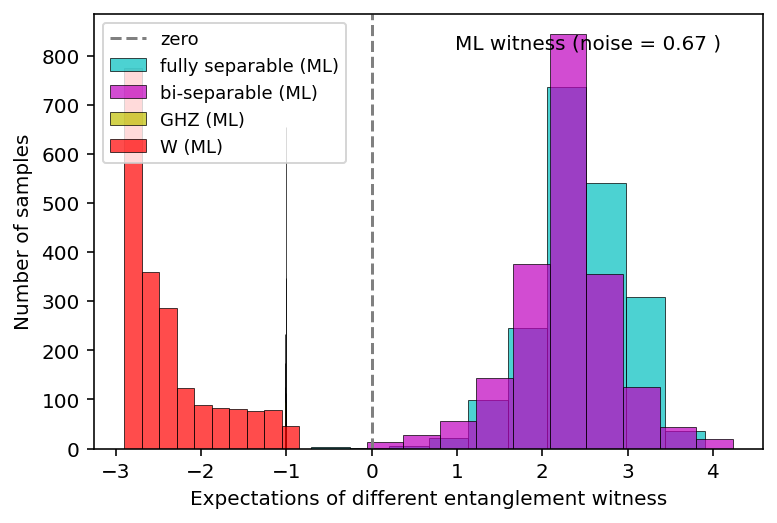

In [5]:
size_train = 2000
size_test = 1000
noise_limit = 4/6

##################### training ########################
# input_states = [generate_rand_product_state(3, 2 * size_train), ghz_3_density, w_3_density]
# labels = [ [1 for i in range(2 * size_train)], [0 for i in range(size_train) ], [0 for i in range(size_train)] ]
# print(labels)
fully_sep_state = generate_rand_product_state(n=3,m=size_train*2,noise_limit=0,is_pure=False)
bi_sep_state    = generate_noisy_biseparable(n_A=1,n_B=2, m=size_train*2,noise_limit=noise_limit)
ghz3_state = generate_coherent_noisy_ghz_ensemble(n=3, m=size_train*2, theta_limit=0.6, phi_limit=0.7)
# ghz3_state      = generate_noisy_ghz_ensemble(n=3,m=size_train*2,noise_limit=noise_limit)
w3_state        = generate_noisy_w_ensemble(n=3,m=size_train*2,noise_limit=noise_limit)

# label the states
fully_sep_data = [fully_sep_state[:size_train] , const_label(1, size_train) ]
bi_sep_data = [bi_sep_state[:size_train], const_label(1,size_train)]
ghz3_data = [ghz3_state[:size_train], const_label(0,size_train)]
w3_data = [w3_state[:size_train], const_label(0,size_train)]

# SVM
three_pauli_tomo_operators = pauli_tensor_observables(n_qubit=3)
three_pauli_tomo_labels = pauli_tensor_labels(n_qubit=3)
X, y = construct_training_dataset(
    states_labels=[fully_sep_data, bi_sep_data, ghz3_data, w3_data],
    operators=three_pauli_tomo_operators)

# (X, Y) = assemble_training_dataset(size_train)
to_features = 5
print(f'# randomly selected features: {to_features}')

accuracy = 0.0
while accuracy < 0.999:
    select_indices = random.sample([i for i in range(len(three_pauli_tomo_operators))], to_features)
    select_labels  = three_pauli_tomo_labels[select_indices]
    print('selected Pauli operators:', select_labels)

    # non-linear kernel SVM
    witness, accuracy = svm_train_witness(X=X[:, select_indices], y=y, size_test=size_test)


##################### testing ########################
# fully_sep_test = generate_rand_product_density(3, size_test)
fully_sep_test = fully_sep_state[size_train:]
bi_sep_test = bi_sep_state[size_train:]
ghz3_test = ghz3_state[size_train:]
w3_test = w3_state[size_train:]

test_dataset = [fully_sep_test, bi_sep_test, ghz3_test, w3_test]

feature_test_set = [evaluate_features(operators=three_pauli_tomo_operators,states=data)[:,select_indices] for data in test_dataset]
test_expectation_lists = evaluate_witness(witness=witness, features_set=feature_test_set)


fig, ax = plt.subplots(figsize=(6, 4))
title = f'ML witness (noise = {noise_limit:.2f} )'
comparison_legend = ['zero', 'fully separable (ML)', 'bi-separable (ML)', 'GHZ (ML)', 'W (ML)']
# three_qubit_legend = ['zero', 'fully separable (GHZ witness)', 'GHZ3 (GHZ witness)', 'W3 (GHZ witness)', 'fully separable (W witness)','W3 (W witness)', 'GHZ (W witness)', 'fully separable (ML)', 'GHZ (ML)', 'W (ML)']
plot_expectation_hist(ax, test_expectation_lists, comparison_legend, title=title)

##################### plot ########################

# fig.show()
plt.savefig('three_qubit_hist_ML.png', dpi=300)


### Non-stabilizer: W state, sqrt(SWAP)
### different partitions

### Unfaithful state - large white noise, coherent noise (local U)
#### W state, four qubit linear cluster state


In [71]:
cluster_4 = generate_linear_cluster(n=4)
# print(cluster_4)

# stabilizer - two local measurement setting
# xzxzxzxz

# print((tensor(plus_state, zero_state, zero_state, plus_state) +
#        tensor(plus_state, zero_state, one_state, minus_state) +
#        tensor(minus_state, one_state, zero_state, plus_state) -
#        tensor(minus_state, one_state, one_state, minus_state)) / 2 - cluster_4)

#### More qubit case

graph state - ring
....

2D cluster state

## Versions of software package/module 

In [13]:
# about()
# conda list
# from qutip.ipynbtools import version_table
# version_table()
# qutip.cite()

print('numpy version:', np.__version__)
print('matplotlib version', mpl.__version__)

import sklearn
print('Scikit-learn version:', sklearn.__version__)
print('QuTiP version:', qutip.__version__)

numpy version: 1.21.5
matplotlib version 3.5.1
Scikit-learn version: 1.1.2
QuTiP version: 4.7.0
